In [1]:
%load_ext autoreload
%autoreload 2

import os

import numpy as np
import tensorflow as tf
from tqdm.autonotebook import tqdm

import data
import plotutils
import train
from models import MlpVae
from tcav import compute_cav
from utils import build_tensor

os.environ['CUDA_VISIBLE_DEVICES'] = '0'
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)
os.makedirs('./figs', exist_ok=True)

# Print output to notebook and file
try:
    os.remove('output_complex.txt')
except OSError:
    pass

old_print = print
def print(*args):
    old_print(*args)
    with open('output_complex.txt', 'a') as f:
        old_print(*args, file=f)

In [2]:
# Initialization

version = 0
seed = 10
tf.random.set_seed(seed)
np.random.seed(seed)

red = (255., 0., 0.)
green = (0., 255., 0.)
blue = (0., 0., 255.)
white = (255., 255., 255.)
gray = (181., 181., 181.)
mint = (186., 255., 205.)
pink = (255., 77., 246.)
yellow = (255., 255., 0.)
orange = (212., 106., 0.)
purple = (122., 30., 150.)

colors = [
    red,
    green,
    blue,
    white,
    gray,
    pink,
    yellow,
    mint,
    orange,
    purple
]

color_names = [
    "red",
    "green",
    "blue",
    "white",
    "gray",
    "pink",
    "yellow",
    "mint",
    "orange",
    "purple"
]

batch_size = 32
latent_dim = 60
vae = MlpVae(latent_dim, save_path='./checkpoints_final/mlp_vae/')
vae_conf = MlpVae(latent_dim, save_path='./checkpoints_final/mlp_vae_conf/')

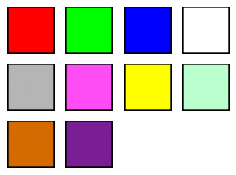

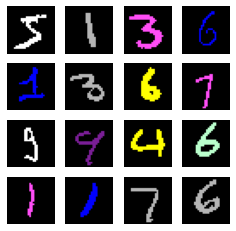

In [3]:
# Display colors and training examples
color_imgs = np.array([None] * 10)
for idx, c in enumerate(colors):
    imgs = data.concept_color_img_tol(c[0], 0, c[1], 0, c[2], 0, n_images=1, img_shape=(28, 28))
    # add black border for white to be visible
    imgs[:, 0, :] = 0
    imgs[:, -1, :] = 0
    imgs[:, :, 0] = 0
    imgs[:, :, -1] = 0
    color_imgs[idx] = imgs[0]

examples, _, _, _ = data.load_preprocessed_mnist(colors)

plotutils.plot_predictions(color_imgs)
plotutils.plot_predictions(examples[::6][:16])

In [4]:
# Unbiased Training
seed = 0
tf.random.set_seed(seed)
np.random.seed(seed)

train_images, _, test_images, _ = data.load_preprocessed_mnist(colors)
train_size = train_images.shape[0]
test_size = test_images.shape[0]

train_dataset = (tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor(train_images, tf.float32))
                 .shuffle(train_size, seed=0).batch(batch_size)).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = (tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor(test_images, tf.float32))
                .shuffle(test_size, seed=-1).batch(batch_size))

train.train(vae, train_dataset, test_dataset, additional_epochs=100, status_report_interval=10)

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 10, Test set ELBO: -33.37305450439453, time elapse for current epoch: 7.432186841964722
Epoch: 20, Test set ELBO: -30.64881134033203, time elapse for current epoch: 6.895809650421143
Epoch: 30, Test set ELBO: -29.817712783813477, time elapse for current epoch: 5.720481634140015
Epoch: 40, Test set ELBO: -29.462675094604492, time elapse for current epoch: 6.098067760467529
Epoch: 50, Test set ELBO: -29.271827697753906, time elapse for current epoch: 6.682547569274902
Epoch: 60, Test set ELBO: -29.111175537109375, time elapse for current epoch: 4.767002582550049
Epoch: 70, Test set ELBO: -29.03783416748047, time elapse for current epoch: 3.979579448699951
Epoch: 80, Test set ELBO: -28.949556350708008, time elapse for current epoch: 4.5860021114349365
Epoch: 90, Test set ELBO: -28.89561653137207, time elapse for current epoch: 4.536325931549072
Epoch: 100, Test set ELBO: -28.853073120117188, time elapse for current epoch: 4.640628337860107


In [5]:
# Biased Training - Color green corrolates to digit 1
seed = 11
tf.random.set_seed(seed)
np.random.seed(seed)

bias_digit = 1
bias_color = green

colors_except_bias = colors.copy()
colors_except_bias.remove(green)
train_images_unbias, _, test_images_unbias, _ = data.load_preprocessed_mnist(colors_except_bias, [0, 2, 3, 4, 5, 6, 7, 8, 9])
train_images_bias, _, test_images_bias, _ = data.load_preprocessed_mnist([bias_color], [bias_digit])

train_images_conf = np.concatenate((train_images_unbias, train_images_bias))
test_images_conf = np.concatenate((test_images_unbias, test_images_bias))

train_size_conf = train_images_conf.shape[0]
test_size_conf = int(train_size_conf / 6)

train_dataset_conf = (tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor(train_images_conf, tf.float32))
                      .shuffle(train_size_conf * 2, seed=0).batch(batch_size))
test_dataset_conf = (tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor(test_images_conf, tf.float32))
                     .shuffle(test_size_conf * 2, seed=-1).batch(batch_size))

train.train(vae_conf, train_dataset_conf, test_dataset_conf, additional_epochs=100, status_report_interval=10)

  0%|          | 0/101 [00:00<?, ?it/s]

Epoch: 10, Test set ELBO: -32.68138122558594, time elapse for current epoch: 4.626866102218628
Epoch: 20, Test set ELBO: -30.52536964416504, time elapse for current epoch: 4.557697534561157
Epoch: 30, Test set ELBO: -29.738096237182617, time elapse for current epoch: 4.307071685791016
Epoch: 40, Test set ELBO: -29.424972534179688, time elapse for current epoch: 4.531022071838379
Epoch: 50, Test set ELBO: -29.1993408203125, time elapse for current epoch: 4.689809560775757
Epoch: 60, Test set ELBO: -29.02398681640625, time elapse for current epoch: 3.5581302642822266
Epoch: 70, Test set ELBO: -28.88263702392578, time elapse for current epoch: 3.7518391609191895
Epoch: 80, Test set ELBO: -28.805898666381836, time elapse for current epoch: 4.744631290435791
Epoch: 90, Test set ELBO: -28.76734733581543, time elapse for current epoch: 4.6684935092926025
Epoch: 100, Test set ELBO: -28.701295852661133, time elapse for current epoch: 4.664681673049927


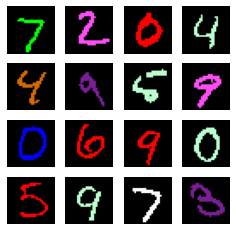

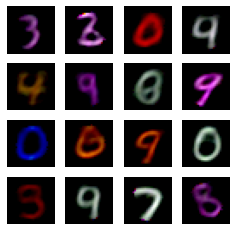

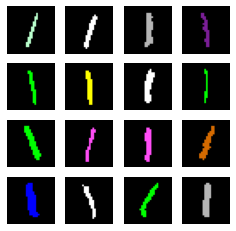

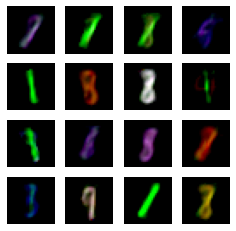

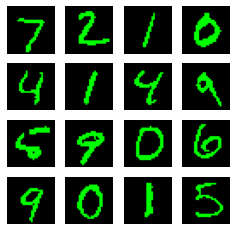

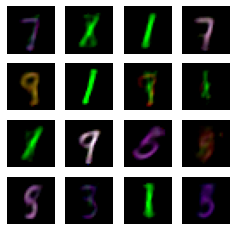

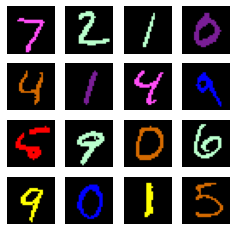

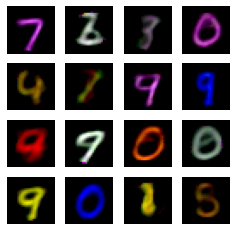

In [6]:
# Some sanity checks for the models
seed = 1337
np.random.seed(seed)
tf.random.set_seed(seed)

iiimmgg_pos, iiimmgg_neg = data.digit_concept_data(1, colors)
iiimmgg_pos_color, iiimmgg_neg_color = data.color_concept_data(green, colors)
for img in [iiimmgg_neg, iiimmgg_pos, iiimmgg_pos_color, iiimmgg_neg_color]:
    test_sample = tf.convert_to_tensor(img[:16])
    plotutils.plot_predictions(test_sample)
    plotutils.plot_reconstructed_images(vae_conf, test_sample)

In [7]:
# Compute CAVs for all concepts - with CONFOUNDER
model = vae_conf
model.load(epoch=100)
n_concept_samples = 200
runs = 20

seed = 1337
tf.random.set_seed(seed)
np.random.seed(seed)

digit_clfs_conf = []
digit_cavs_conf = []
color_clfs_conf = []
color_cavs_conf = []

print("\nAccuracies for vae with confounder:")
# Compute CAVs for all digits and colors
for i in tqdm(range(10)):
    digit = i
    color = colors[i]

    d_clfs = []
    d_cavs = []
    c_clfs = []
    c_cavs = []

    # Do multiple runs to get reliable results
    for r in range(runs):
        seed = i + r * 1
        np.random.seed(seed)
        tf.random.set_seed(seed)

        # Digit CAV
        P_digit, N_digit = data.digit_concept_data(digit, colors)
        P_digit = build_tensor(P_digit, n_concept_samples=n_concept_samples)
        N_digit = build_tensor(N_digit, n_concept_samples=n_concept_samples)
        cav_digit, clf_digit = compute_cav(model, P_digit, N_digit)
        d_clfs.append(clf_digit)
        d_cavs.append(cav_digit)
        print(f"{digit}:\t Acc={clf_digit.history.history['val_accuracy'][-1]}")

        # Color CAV
        P_color, N_color = data.color_concept_data(color, colors)
        P_color = build_tensor(P_color, n_concept_samples=n_concept_samples)
        N_color = build_tensor(N_color, n_concept_samples=n_concept_samples)
        cav_color, clf_color = compute_cav(model, P_color, N_color)
        c_clfs.append(clf_color)
        c_cavs.append(cav_color)
        print(f"{color_names[i]}:\t Acc={clf_color.history.history['val_accuracy'][-1]}")

    digit_clfs_conf.append(d_clfs)
    digit_cavs_conf.append(d_cavs)
    color_clfs_conf.append(c_clfs)
    color_cavs_conf.append(c_cavs)


Accuracies for vae with confounder:


  0%|          | 0/10 [00:00<?, ?it/s]

0:	 Acc=0.7749999761581421
red:	 Acc=0.875
0:	 Acc=0.7250000238418579
red:	 Acc=0.762499988079071
0:	 Acc=0.7875000238418579
red:	 Acc=0.9125000238418579
0:	 Acc=0.887499988079071
red:	 Acc=0.862500011920929
0:	 Acc=0.800000011920929
red:	 Acc=0.8500000238418579
0:	 Acc=0.800000011920929
red:	 Acc=0.8125
0:	 Acc=0.8374999761581421
red:	 Acc=0.7875000238418579
0:	 Acc=0.8500000238418579
red:	 Acc=0.8999999761581421
0:	 Acc=0.800000011920929
red:	 Acc=0.8374999761581421
0:	 Acc=0.800000011920929
red:	 Acc=0.8500000238418579
0:	 Acc=0.800000011920929
red:	 Acc=0.9125000238418579
0:	 Acc=0.8125
red:	 Acc=0.925000011920929
0:	 Acc=0.737500011920929
red:	 Acc=0.8999999761581421
0:	 Acc=0.762499988079071
red:	 Acc=0.8374999761581421
0:	 Acc=0.7875000238418579
red:	 Acc=0.9624999761581421
0:	 Acc=0.800000011920929
red:	 Acc=0.7749999761581421
0:	 Acc=0.7875000238418579
red:	 Acc=0.824999988079071
0:	 Acc=0.737500011920929
red:	 Acc=0.925000011920929
0:	 Acc=0.800000011920929
red:	 Acc=0.862500

7:	 Acc=0.7749999761581421
mint:	 Acc=0.762499988079071
7:	 Acc=0.75
mint:	 Acc=0.5375000238418579
7:	 Acc=0.8374999761581421
mint:	 Acc=0.637499988079071
8:	 Acc=0.6499999761581421
orange:	 Acc=0.762499988079071
8:	 Acc=0.612500011920929
orange:	 Acc=0.7250000238418579
8:	 Acc=0.612500011920929
orange:	 Acc=0.675000011920929
8:	 Acc=0.75
orange:	 Acc=0.637499988079071
8:	 Acc=0.699999988079071
orange:	 Acc=0.6875
8:	 Acc=0.637499988079071
orange:	 Acc=0.675000011920929
8:	 Acc=0.7124999761581421
orange:	 Acc=0.7250000238418579
8:	 Acc=0.625
orange:	 Acc=0.637499988079071
8:	 Acc=0.675000011920929
orange:	 Acc=0.7250000238418579
8:	 Acc=0.6000000238418579
orange:	 Acc=0.7749999761581421
8:	 Acc=0.637499988079071
orange:	 Acc=0.675000011920929
8:	 Acc=0.637499988079071
orange:	 Acc=0.7250000238418579
8:	 Acc=0.5375000238418579
orange:	 Acc=0.737500011920929
8:	 Acc=0.6000000238418579
orange:	 Acc=0.7250000238418579
8:	 Acc=0.6625000238418579
orange:	 Acc=0.75
8:	 Acc=0.699999988079071
o

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

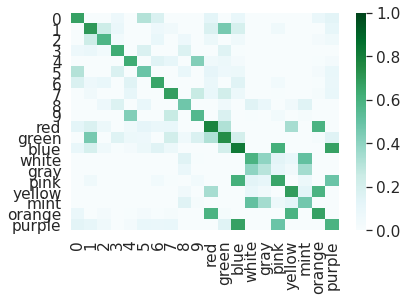

In [8]:
# Compute average TCAV score for every possible combination, plot as heatmap

tcav_scores_conf = np.zeros((20, 20))
for i in tqdm(range(20)):
    for j in tqdm(range(20)):
        scores = np.zeros((runs * runs,))

        # Compute dotproduct for all combinations using the concepts i and j (digit or color)
        for i_runs in range(runs):
            for j_runs in range(runs):
                # if i < 10, then treat as digit, else treat as color (same for j)
                cav_1 = (digit_cavs_conf[i] if i < 10 else color_cavs_conf[i - 10])[i_runs]
                cav_2 = (digit_cavs_conf[j] if j < 10 else color_cavs_conf[j - 10])[j_runs]
                scores[i_runs * runs + j_runs] = tf.tensordot(tf.transpose(cav_1), cav_2, axes=1).numpy()[0][0]

        tcav_scores_conf[i, j] = np.average(scores)
        # if (i < 10 and j > 10):
        #    print(f"{i} and {color_names[j-10]} = {tcav_scores[i,j]}")

# Visualization as heatmap, ignoring values < 0 because we are only interested in positive correlations
labels = [str(i) if i < 10 else color_names[i - 10] for i in range(20)]
tcav_scores_clipped = np.clip(tcav_scores_conf, 0, 1)
plotutils.heatmap(tcav_scores_clipped, labels, filename='./figs/mlpvae_conf_complex.png')

In [ ]:
# Compute CAVs for all concepts - without bias
model = vae
model.load(epoch=100)
n_concept_samples = 200
runs = 20

seed = 1337
tf.random.set_seed(seed)
np.random.seed(seed)

digit_clfs = []
digit_cavs = []
color_clfs = []
color_cavs = []

print("\nAccuracies for unbiased vae:")
# Compute CAVs for all digits and colors
for i in tqdm(range(10)):
    digit = i
    color = colors[i]

    d_clfs = []
    d_cavs = []
    c_clfs = []
    c_cavs = []

    # Do multiple runs to get reliable results
    for r in range(runs):
        seed = i + r * 1
        np.random.seed(seed)
        tf.random.set_seed(seed)

        # Digit CAV
        P_digit, N_digit = data.digit_concept_data(digit, colors)
        P_digit = build_tensor(P_digit, n_concept_samples=n_concept_samples)
        N_digit = build_tensor(N_digit, n_concept_samples=n_concept_samples)
        cav_digit, clf_digit = compute_cav(model, P_digit, N_digit)
        d_clfs.append(clf_digit)
        d_cavs.append(cav_digit)
        print(f"{digit}:\t Acc={clf_digit.history.history['val_accuracy'][-1]}")

        # Color CAV
        P_color, N_color = data.color_concept_data(color, colors)
        P_color = build_tensor(P_color, n_concept_samples=n_concept_samples)
        N_color = build_tensor(N_color, n_concept_samples=n_concept_samples)
        cav_color, clf_color = compute_cav(model, P_color, N_color)
        c_clfs.append(clf_color)
        c_cavs.append(cav_color)
        print(f"{color_names[i]}:\t Acc={clf_color.history.history['val_accuracy'][-1]}")

    digit_clfs.append(d_clfs)
    digit_cavs.append(d_cavs)
    color_clfs.append(c_clfs)
    color_cavs.append(c_cavs)


Accuracies for unbiased vae:


  0%|          | 0/10 [00:00<?, ?it/s]

0:	 Acc=0.8125
red:	 Acc=0.9125000238418579
0:	 Acc=0.7875000238418579
red:	 Acc=0.7749999761581421
0:	 Acc=0.800000011920929
red:	 Acc=0.925000011920929
0:	 Acc=0.8999999761581421
red:	 Acc=0.875
0:	 Acc=0.8374999761581421
red:	 Acc=0.8999999761581421
0:	 Acc=0.862500011920929
red:	 Acc=0.8999999761581421
0:	 Acc=0.824999988079071
red:	 Acc=0.8500000238418579
0:	 Acc=0.9125000238418579
red:	 Acc=0.875
0:	 Acc=0.8374999761581421
red:	 Acc=0.875
0:	 Acc=0.862500011920929
red:	 Acc=0.824999988079071
0:	 Acc=0.7875000238418579
red:	 Acc=0.8500000238418579
0:	 Acc=0.875
red:	 Acc=0.862500011920929
0:	 Acc=0.8374999761581421
red:	 Acc=0.9125000238418579
0:	 Acc=0.875
red:	 Acc=0.8374999761581421
0:	 Acc=0.8374999761581421
red:	 Acc=0.925000011920929
0:	 Acc=0.800000011920929
red:	 Acc=0.8374999761581421
0:	 Acc=0.824999988079071
red:	 Acc=0.8500000238418579
0:	 Acc=0.762499988079071
red:	 Acc=0.9624999761581421
0:	 Acc=0.8374999761581421
red:	 Acc=0.8374999761581421
0:	 Acc=0.82499998807907

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

0 and green = -0.02095410166773945
0 and blue = 0.06071127800270915
0 and white = -0.09973033230751753
0 and gray = -0.07086580837436486
0 and pink = -0.046480728568858466
0 and yellow = -0.04938307769596577
0 and mint = -0.11589725441299378
0 and orange = 0.08803703717363533
0 and purple = 0.06082973346114159


  0%|          | 0/20 [00:00<?, ?it/s]

1 and green = 0.11959518835879862
1 and blue = 0.13457392951473593
1 and white = -0.20365939318202436
1 and gray = -0.11739111677743494
1 and pink = -0.012759581387508661
1 and yellow = -0.04036942217499018
1 and mint = -0.125396407765802
1 and orange = 0.13205891956575214
1 and purple = 0.1367514752037823


  0%|          | 0/20 [00:00<?, ?it/s]

2 and green = -0.013056935847271234
2 and blue = -0.02557378347031772
2 and white = -0.024263763618655503
2 and gray = -0.049548551255138594
2 and pink = -0.022586333049694075
2 and yellow = 0.03318002020940185
2 and mint = -0.05529611714184284
2 and orange = 0.0769318684778409
2 and purple = 0.004536961372941732


  0%|          | 0/20 [00:00<?, ?it/s]

3 and green = -0.008760008216486313
3 and blue = 0.009002603162662126
3 and white = 0.012792574125342071
3 and gray = 0.022599061746150256
3 and pink = 0.024688001062022524
3 and yellow = -0.021526141489157453
3 and mint = 0.02228042706658016
3 and orange = -0.000277130210888572
3 and purple = 0.03005584164056927


  0%|          | 0/20 [00:00<?, ?it/s]

4 and green = 0.05180020821979269
4 and blue = 0.036302710212767125
4 and white = -0.1017389852181077
4 and gray = -0.07674382945522666
4 and pink = -0.054186841887421906
4 and yellow = 0.0012618899438530207
4 and mint = -0.0825556118087843
4 and orange = 0.03631119790719822
4 and purple = 0.015165805909782648


  0%|          | 0/20 [00:00<?, ?it/s]

5 and green = 0.1243676060589496
5 and blue = 0.07035467282868922
5 and white = -0.06562574251787737
5 and gray = 0.019937886805273593
5 and pink = -0.05407663490041159
5 and yellow = -0.10763759128632955
5 and mint = 0.012290372246643528
5 and orange = -0.02949679564277176
5 and purple = 0.08010069373995066


  0%|          | 0/20 [00:00<?, ?it/s]

6 and green = 0.039126382101676425
6 and blue = 0.07668835534248501
6 and white = -0.1051297241350403
6 and gray = -0.06868709114671219
6 and pink = -0.013079768666066229
6 and yellow = -0.043352959761396054
6 and mint = -0.0905563524653553
6 and orange = 0.06530041735750274
6 and purple = 0.08147362871095538


  0%|          | 0/20 [00:00<?, ?it/s]

7 and green = 0.0330027903849259
7 and blue = 0.03307498550973833
7 and white = -0.09970169686712324
7 and gray = -0.07443800664041192
7 and pink = -0.042720021328423174
7 and yellow = 0.022657131040468813
7 and mint = -0.08217767909169198
7 and orange = 0.0875274049626023
7 and purple = 0.03930311822332442


  0%|          | 0/20 [00:00<?, ?it/s]

8 and green = -0.13873077365686184
8 and blue = -0.12425252985674888
8 and white = 0.21182383697945625
8 and gray = 0.12403867835178971
8 and pink = 0.08023273243103177
8 and yellow = 0.04687376629561186
8 and mint = 0.1548108803643845
8 and orange = -0.13037310305051505
8 and purple = -0.14663143665995448


  0%|          | 0/20 [00:00<?, ?it/s]

9 and green = -0.07926088103558868
9 and blue = 0.026815781882032753
9 and white = 0.026721427966840565
9 and gray = 0.014599939981126226
9 and pink = 0.05181760979699902
9 and yellow = -0.009520040275529027
9 and mint = 0.013432555636391043
9 and orange = -0.0508710396673996
9 and purple = -0.01100186618976295


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

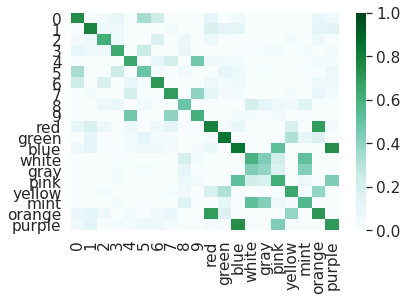

In [11]:
# Compute average TCAV score for every possible combination, plot as heatmap

tcav_scores = np.zeros((20, 20))
for i in tqdm(range(20)):
    for j in tqdm(range(20)):
        scores = np.zeros((runs * runs,))

        # Compute dotproduct for all combinations using the concepts i and j (digit or color)
        for i_runs in range(runs):
            for j_runs in range(runs):
                # if i < 10, then treat as digit, else treat as color (same for j)
                cav_1 = (digit_cavs[i] if i < 10 else color_cavs[i - 10])[i_runs]
                cav_2 = (digit_cavs[j] if j < 10 else color_cavs[j - 10])[j_runs]
                scores[i_runs * runs + j_runs] = tf.tensordot(tf.transpose(cav_1), cav_2, axes=1).numpy()[0][0]

        tcav_scores[i, j] = np.average(scores)
        if i < 10 and j > 10:
            print(f"{i} and {color_names[j-10]} = {tcav_scores[i,j]}")

# Visualization as heatmap, ignoring values < 0 because we are only interested in positive correlations
labels = [str(i) if i < 10 else color_names[i - 10] for i in range(20)]
tcav_scores_clipped = np.clip(tcav_scores, 0, 1)
plotutils.heatmap(tcav_scores_clipped, labels, filename='./figs/mlpvae_pure_complex.png')